Случайный лес: ансамбли деревьев = бэггинг фичей и объектов + блендинг

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

![ensemble_idea](forrest_idea.png)

In [2]:
X, y = load_digits(n_class=10, return_X_y=True)

In [3]:
X.shape

(1797, 64)

## 1. Случайные подмножества признаков

In [28]:
predict_proba_models = []

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=1)

for state in range(5):
    
    model = DecisionTreeClassifier(max_features=4,
                                   max_depth=2,
                                   random_state=state)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    predict_proba_models.append(y_pred)

    y_pred = model.predict(X_test)

    print('Точность классификатора: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Признаки по которым проходило разделение: {}'.format(np.nonzero(model.feature_importances_)))
    print('\n-------\n')

Точность классификатора: 0.313
Признаки по которым проходило разделение: (array([10, 33, 43]),)

-------

Точность классификатора: 0.340
Признаки по которым проходило разделение: (array([21, 50, 54]),)

-------

Точность классификатора: 0.337
Признаки по которым проходило разделение: (array([ 2, 25, 44]),)

-------

Точность классификатора: 0.301
Признаки по которым проходило разделение: (array([10, 28, 61]),)

-------

Точность классификатора: 0.274
Признаки по которым проходило разделение: (array([36, 43, 58]),)

-------



In [29]:
predict_proba_models = np.array(predict_proba_models)

print(predict_proba_models.shape)

mean_predict_proba = predict_proba_models.sum(axis=0) / 5
mean_predict = np.argmax(mean_predict_proba, axis=1)

print(accuracy_score(y_test, mean_predict))

(5, 594, 10)
0.6430976430976431


## 2. Случайные подмножества объектов

In [5]:
predict_proba_models = []


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=1)

def bootstrap_indices(random_state, n_samples):
    """Private function used to _parallel_build_trees function."""
    random_instance = np.random.RandomState(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_samples)

    return sample_indices

for state in range(5):
   
    ind = bootstrap_indices(state, X_train.shape[0])
    X_train_, y_train_ = X_train[ind], y_train[ind]
    
    model = DecisionTreeClassifier(max_features=4,
                                   max_depth=2,
                                   random_state=2)

    model.fit(X_train_, y_train_)
    y_pred = model.predict_proba(X_test)
    
    predict_proba_models.append(y_pred)
    
    y_pred = model.predict(X_test)
    print('Точность классификатора: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Признаки по которым проходило разделение: {}'.format(np.nonzero(model.feature_importances_)))
    print('\n-------\n')

Точность классификатора: 0.241
Признаки по которым проходило разделение: (array([19, 25, 49]),)

-------

Точность классификатора: 0.310
Признаки по которым проходило разделение: (array([ 2, 25, 44]),)

-------

Точность классификатора: 0.224
Признаки по которым проходило разделение: (array([ 2, 19, 25]),)

-------

Точность классификатора: 0.229
Признаки по которым проходило разделение: (array([ 6, 19, 25]),)

-------

Точность классификатора: 0.237
Признаки по которым проходило разделение: (array([ 2, 19, 25]),)

-------



In [6]:
predict_proba_models = np.array(predict_proba_models)

print(predict_proba_models.shape)

mean_predict_proba = predict_proba_models.sum(axis=0) / 5
mean_predict = np.argmax(mean_predict_proba, axis=1)

print(accuracy_score(y_test, mean_predict))

(5, 594, 10)
0.3552188552188552


## 3. Случайные признаки + Сэмплинг данных

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1)

#-------------------------------------------------------------------------------------------
# TRAINING

models = []
rs = list(range(5))

for state in rs:
    
    ind = bootstrap_indices(state, X_train.shape[0])
    X_train_, y_train_ = X_train[ind], y_train[ind]
    
    model = DecisionTreeClassifier(max_features=32,
                                   splitter = 'best',
                                   max_depth=4,
                                   random_state=state+10)

    model.fit(X_train_, y_train_)    
    models.append(model)

    
#-------------------------------------------------------------------------------------------
# PREDICTION

predict_proba_models = []


for model in models:

    y_pred = model.predict_proba(X_test)
    predict_proba_models.append(y_pred)
    y_pred = model.predict(X_test)

    print('Точность классификатора: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    
    
predict_proba_models = np.array(predict_proba_models)

print(predict_proba_models.shape)

mean_predict_proba = predict_proba_models.sum(axis=0) / 5
mean_predict = np.argmax(mean_predict_proba, axis=1)

print(accuracy_score(y_test, mean_predict))

Точность классификатора: 0.551
Точность классификатора: 0.630
Точность классификатора: 0.694
Точность классификатора: 0.657
Точность классификатора: 0.567
(5, 594, 10)
0.8198653198653199


## 4. Случайный лес 

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

model = RandomForestClassifier(n_estimators=5,
                               max_features=32,
                               max_depth=4,
                               random_state=1) 

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.7777777777777778


In [10]:
rs = []
for m in model.estimators_:
    rs.append(m.random_state)

In [11]:
rs

[1791095845, 2135392491, 946286476, 1857819720, 491263]

In [12]:
model.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features=32, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1791095845, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features=32, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=2135392491, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
             max_features=32, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.

In [13]:
# from sklearn.tree import export_graphviz

# for est,i in zip(model.estimators_,range(5)):
#     export_graphviz(est, out_file='tree{}.dot'.format(i), filled=True)

In [14]:
# !dot -Tpng 'tree0.dot' -o 'tree0.png'

### 4.1. Параметры Случайного леса: число деревьев

In [15]:
X_train.shape

(1203, 64)

In [16]:
X_test.shape

(594, 64)

In [17]:
acc_train = []
acc_test = []

for n in tqdm_notebook(range(1,100,2)):
    
    model = RandomForestClassifier(n_estimators=n,
                                   max_features=4,
                                   max_depth=2,
                                   random_state=1, n_jobs=-1) 
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, y_pred))

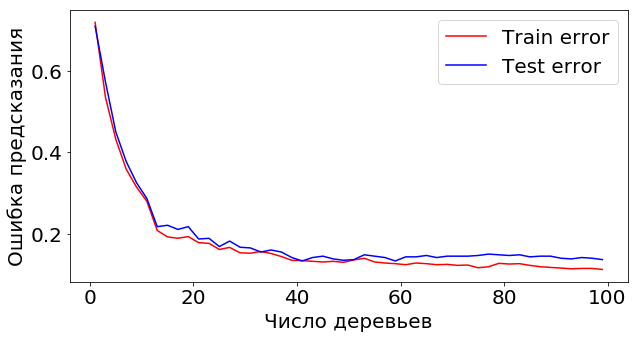

In [18]:
plt.rc('font', **{'size':20})

plt.figure(figsize=(10,5))
plt.plot(list(range(1,100,2)), 1-np.array(acc_train), c='r', label='Train error')
plt.plot(list(range(1,100,2)), 1-np.array(acc_test), c='b', label='Test error')
plt.xlabel('Число деревьев')
plt.ylabel('Ошибка предсказания')
plt.legend();

### 4.2. Параметры Случайного леса: глубина дерева

In [23]:
acc_train = []
acc_test = []

for n in tqdm_notebook(range(1,20,1)):
    
    model = RandomForestClassifier(n_estimators=5,
                                   max_features=4,
                                   max_depth=n,
                                   random_state=1, n_jobs=-1) 
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, y_pred))

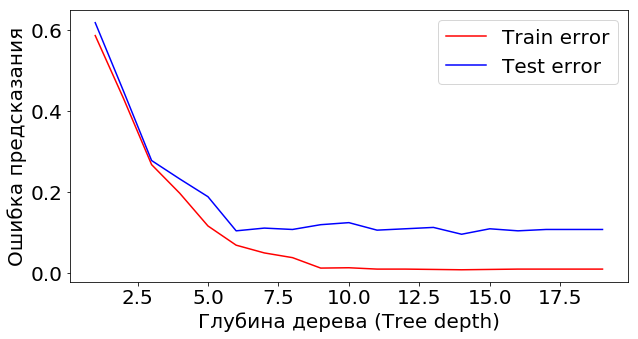

In [24]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,20,1)), 1-np.array(acc_train), c='r', label='Train error')
plt.plot(list(range(1,20,1)), 1-np.array(acc_test), c='b', label='Test error')
plt.xlabel('Глубина дерева (Tree depth)')
plt.ylabel('Ошибка предсказания')
plt.legend();

### 4.3. Параметры Случайного леса: количество признаков

In [21]:
acc_train = []
acc_test = []

for n in tqdm_notebook(range(1,64)):
    
    model = RandomForestClassifier(n_estimators=15,
                                   max_features=n,
                                   max_depth=2,
                                   random_state=1, n_jobs=-1) 
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, y_pred))

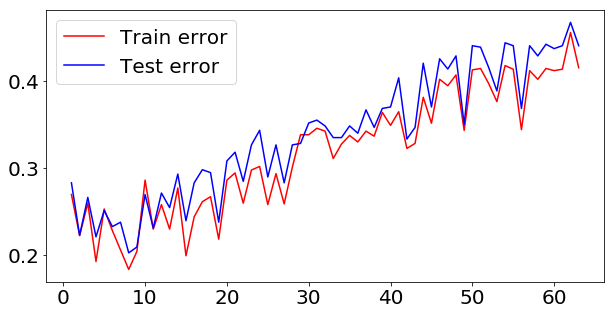

In [32]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,64)), 1-np.array(acc_train), c='r', label='Train error')
plt.plot(list(range(1,64)), 1-np.array(acc_test), c='b', label='Test error')

plt.legend();

## Деревья на случайных признаках

выбор признака в узле с вероятностью, зачем?

Ответ- помогает сильно скорелированным признакам
получить +- одинаковый вес (если брать аргмакс то какой то признак может сильно просесть)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

model = ExtraTreesClassifier(n_estimators=5, max_features=4, max_depth=2, random_state=1, bootstrap=True) 

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))